                               SARIMAX Results                                
Dep. Variable:             gdp_growth   No. Observations:                  133
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -94.237
Date:                Wed, 26 Nov 2025   AIC                            200.474
Time:                        16:41:27   BIC                            217.679
Sample:                    06-30-1992   HQIC                           207.465
                         - 06-30-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
indpro_growth     0.3366      0.022     15.022      0.000       0.293       0.380
rsxfs_growth      0.0533      0.027      1.961      0.050    2.73e-05       0.107
icsa_growth      -0.0180      0.002    -

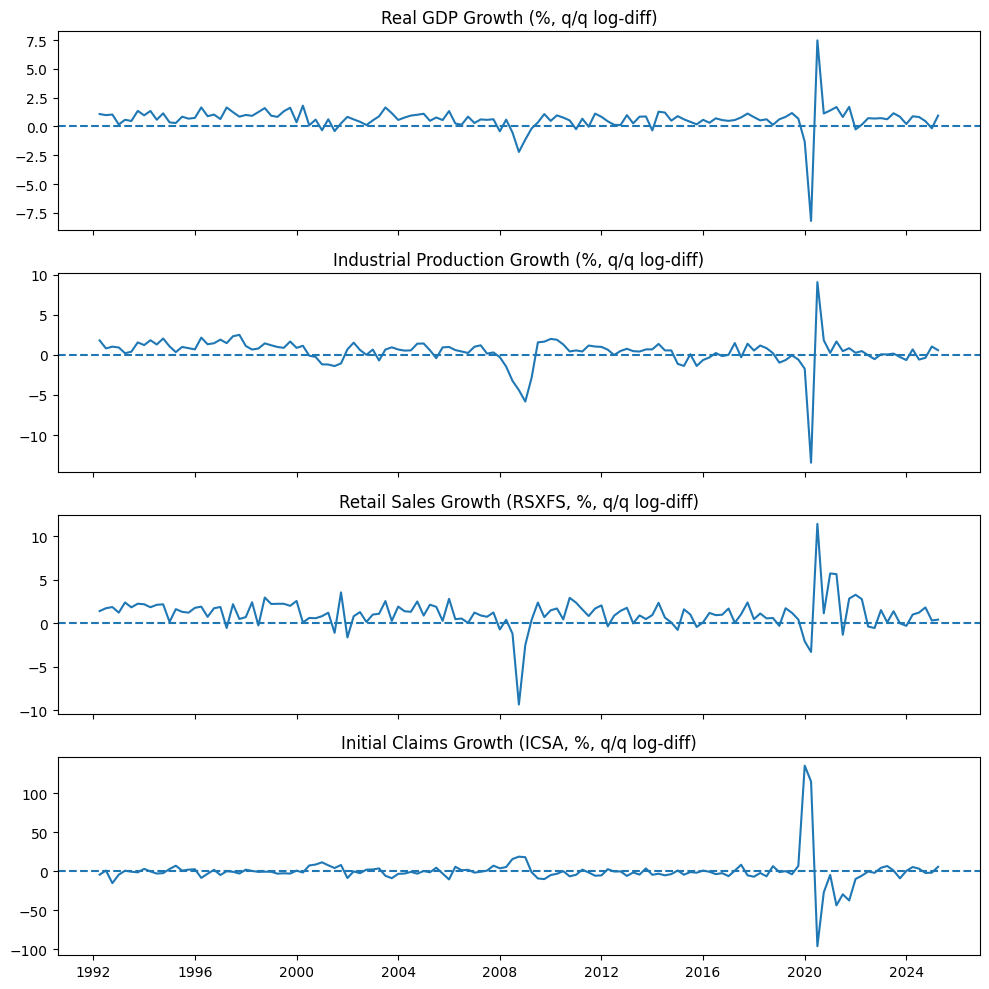

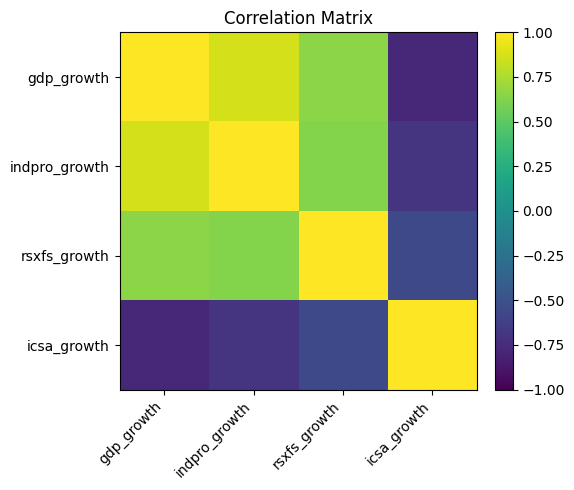

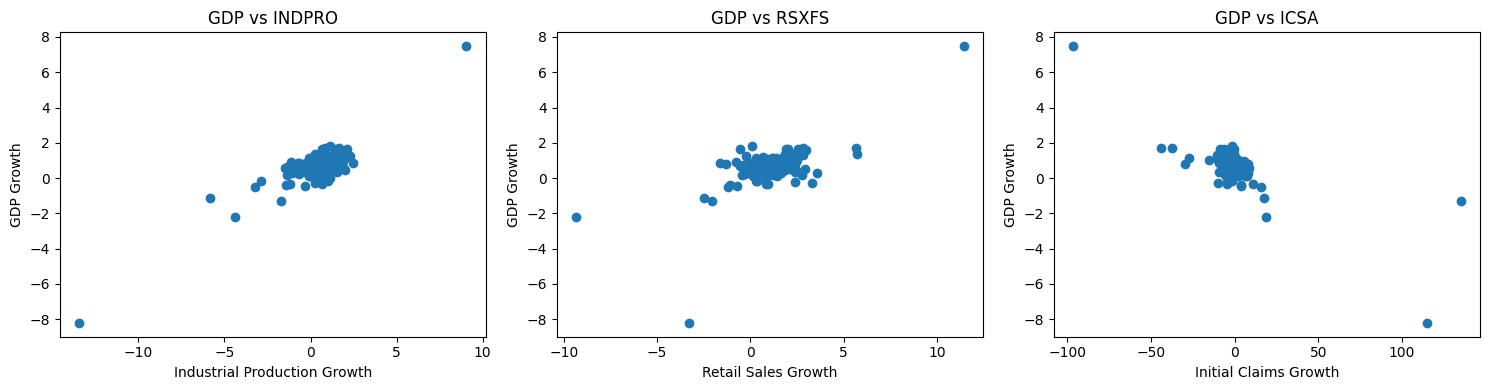

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# -----------------------------
# Load FRED series
# -----------------------------
BASE_URL = "https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"

def load_fred(series_id):
    """
    Loads a FRED CSV directly from the URL.
    Handles either DATE or observation_date as the date column.
    Returns a DataFrame with:
        index: DatetimeIndex
        column: series_id (numeric)
    """
    url = BASE_URL.format(series_id=series_id)
    df = pd.read_csv(url)

    # FRED sometimes uses DATE, sometimes observation_date
    if "DATE" in df.columns:
        date_col = "DATE"
    else:
        date_col = "observation_date"

    df[date_col] = pd.to_datetime(df[date_col])
    df = df.rename(columns={date_col: "date"})
    df = df.set_index("date").sort_index()

    # force numeric, turn "." into NaN etc.
    df[series_id] = pd.to_numeric(df[series_id], errors="coerce")

    return df[[series_id]]

# -----------------------------
# Download the series
# -----------------------------
# Target: Real GDP (quarterly)
gdp = load_fred("GDPC1")

# Exogenous predictors (monthly/weekly)
indpro = load_fred("INDPRO")   # Industrial Production
rsxfs  = load_fred("RSXFS")    # Advance Retail Sales: Retail Trade
icsa   = load_fred("ICSA")     # Initial Claims

# -----------------------------
# Convert everything to quarterly
# -----------------------------
# GDP: already quarterly
gdp_q = gdp.copy()
gdp_q["period"] = gdp_q.index.to_period("Q")
gdp_q = gdp_q.groupby("period")["GDPC1"].last()

def to_quarterly_mean(df, col):
    temp = df.copy()
    temp["period"] = temp.index.to_period("Q")
    return temp.groupby("period")[col].mean()

indpro_q = to_quarterly_mean(indpro, "INDPRO")
rsxfs_q  = to_quarterly_mean(rsxfs,  "RSXFS")
icsa_q   = to_quarterly_mean(icsa,   "ICSA")

# -----------------------------
# Merge into one quarterly DataFrame
# -----------------------------
data_q = pd.concat(
    [gdp_q, indpro_q, rsxfs_q, icsa_q],
    axis=1,
    join="inner"
)
data_q.columns = ["gdp_level", "indpro_level", "rsxfs_level", "icsa_level"]
data_q = data_q.dropna()

# -----------------------------
# Make growth rates (log-diffs)
# -----------------------------
df = pd.DataFrame(index=data_q.index)

df["gdp_growth"]      = 100 * np.log(data_q["gdp_level"]).diff()
df["indpro_growth"]   = 100 * np.log(data_q["indpro_level"]).diff()
df["rsxfs_growth"]    = 100 * np.log(data_q["rsxfs_level"]).diff()
df["icsa_growth"]     = 100 * np.log(data_q["icsa_level"]).diff()

df = df.dropna()  # drop first NA from differencing

# -----------------------------
# ARIMAX model
# -----------------------------
y = df["gdp_growth"]
X = df[["indpro_growth", "rsxfs_growth", "icsa_growth"]]

model = sm.tsa.SARIMAX(
    y,
    exog=X,
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())

# -----------------------------
# One-step-ahead forecast
# -----------------------------
X_next = X.iloc[[-1]]  # last row as 1-row DataFrame

forecast = results.get_forecast(steps=1, exog=X_next)
mean_forecast = forecast.predicted_mean.iloc[0]
conf_int = forecast.conf_int().iloc[0]

print("\nNext-quarter GDP growth forecast:")
print(f"Point forecast: {mean_forecast:.3f} %")
print("95% CI:")
print(conf_int)

# =====================================================
# PLOTS
# =====================================================

# ---- 7.1 Time series: GDP growth and predictors ----
fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

axes[0].plot(df.index.to_timestamp(), df["gdp_growth"])
axes[0].set_title("Real GDP Growth (%, q/q log-diff)")
axes[0].axhline(0, linestyle="--")

axes[1].plot(df.index.to_timestamp(), df["indpro_growth"])
axes[1].set_title("Industrial Production Growth (%, q/q log-diff)")
axes[1].axhline(0, linestyle="--")

axes[2].plot(df.index.to_timestamp(), df["rsxfs_growth"])
axes[2].set_title("Retail Sales Growth (RSXFS, %, q/q log-diff)")
axes[2].axhline(0, linestyle="--")

axes[3].plot(df.index.to_timestamp(), df["icsa_growth"])
axes[3].set_title("Initial Claims Growth (ICSA, %, q/q log-diff)")
axes[3].axhline(0, linestyle="--")

plt.tight_layout()
plt.show()

# ---- 7.2 Correlation heatmap (for multicollinearity) ----
corr_vars = ["gdp_growth", "indpro_growth", "rsxfs_growth", "icsa_growth"]
corr = df[corr_vars].corr()

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr, vmin=-1, vmax=1)

ax.set_xticks(range(len(corr_vars)))
ax.set_xticklabels(corr_vars, rotation=45, ha="right")
ax.set_yticks(range(len(corr_vars)))
ax.set_yticklabels(corr_vars)

ax.set_title("Correlation Matrix")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# ---- 7.3 Scatter plots: GDP growth vs each predictor ----
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(df["indpro_growth"], df["gdp_growth"])
axes[0].set_xlabel("Industrial Production Growth")
axes[0].set_ylabel("GDP Growth")
axes[0].set_title("GDP vs INDPRO")

axes[1].scatter(df["rsxfs_growth"], df["gdp_growth"])
axes[1].set_xlabel("Retail Sales Growth")
axes[1].set_ylabel("GDP Growth")
axes[1].set_title("GDP vs RSXFS")

axes[2].scatter(df["icsa_growth"], df["gdp_growth"])
axes[2].set_xlabel("Initial Claims Growth")
axes[2].set_ylabel("GDP Growth")
axes[2].set_title("GDP vs ICSA")

plt.tight_layout()
plt.show()


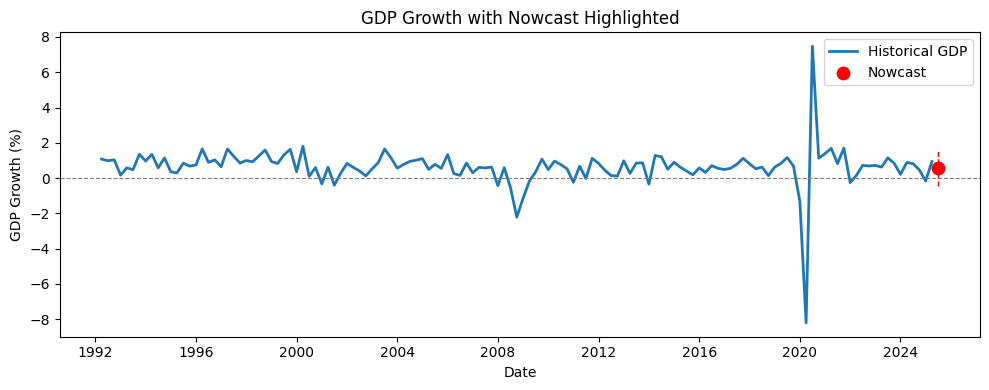

In [ ]:
# -----------------------------
# Plot GDP with nowcast highlighted
# -----------------------------
# Next-quarter date (one period after last historical observation)
last_period = df.index[-1]
next_period = last_period + 1
next_date = next_period.to_timestamp()   # convert quarterly period to timestamp

fig, ax = plt.subplots(figsize=(10, 4))

# Historical GDP growth line
ax.plot(df.index.to_timestamp(), df["gdp_growth"],
        label="Historical GDP", linewidth=2)

# Nowcast point
ax.scatter(next_date, mean_forecast, s=80,
           color="red", label="Nowcast", zorder=5)

# Error bar for 95% CI
ax.vlines(next_date, conf_int["lower gdp_growth"], conf_int["upper gdp_growth"],
          colors="red", linestyles="dashed", linewidth=1)

ax.set_title("GDP Growth with Nowcast Highlighted")
ax.set_xlabel("Date")
ax.set_ylabel("GDP Growth (%)")
ax.legend()
ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)

plt.tight_layout()
plt.show()


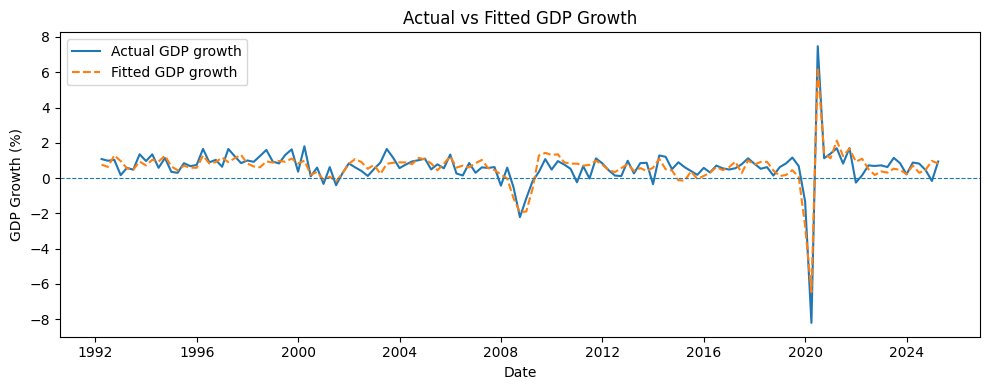

In [7]:
fitted = results.fittedvalues  # model's in-sample fitted GDP growth

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.index.to_timestamp(), df["gdp_growth"], label="Actual GDP growth")
ax.plot(df.index.to_timestamp(), fitted, label="Fitted GDP growth", linestyle="--")
ax.axhline(0, linestyle="--", linewidth=0.8)
ax.set_title("Actual vs Fitted GDP Growth")
ax.set_xlabel("Date")
ax.set_ylabel("GDP Growth (%)")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error

# simple train-test split: last 20 quarters as test
split = -20
y_train, y_test = y.iloc[:split], y.iloc[split:]
X_train, X_test = X.iloc[:split], X.iloc[split:]

# refit model on train
model_tt = sm.tsa.SARIMAX(
    y_train, exog=X_train, order=(1,1,1),
    enforce_stationarity=False, enforce_invertibility=False
)
res_tt = model_tt.fit(disp=False)

# ARIMAX forecast on test
pred_arimax = res_tt.get_forecast(steps=len(y_test), exog=X_test).predicted_mean

# naive forecast: next quarter = previous quarter
naive_pred = y_test.shift(1)  # use previous observed value
naive_pred.iloc[0] = y_train.iloc[-1]  # first test forecast = last train value

mae_arimax = mean_absolute_error(y_test, pred_arimax)
mae_naive  = mean_absolute_error(y_test, naive_pred)

print(f"MAE naive:  {mae_naive:.3f} percentage points")
print(f"MAE ARIMAX: {mae_arimax:.3f} percentage points")

MAE naive:  1.585 percentage points
MAE ARIMAX: 0.446 percentage points
